In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random

import matplotlib.pyplot as plt
import time

from model import ConvNet
from CustomDataset import get_dataset

/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/nfs4/ushashi/anaconda3/envs/gpu_ptorch/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/nfs4/ushashi/anaconda3/envs/gp

In [2]:
random.seed(20)
np.random.seed(20)


NUM_MAPS = 5*20*20
LEARNINGRATE = 8e-3
GAMMA = 0.9

BATCHSIZE = 256
NUMEPOCHS = 11

LOG_SOFTMAX_VALUES = False

dset = get_dataset('20news-bydate-test')

FILE = 'weights/Model_quicksave40.pt'


class_names = dset.classes
print(class_names)


rand_files = random.sample(range(len(dset)), NUM_MAPS)

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [3]:
model = ConvNet(LOG_SOFTMAX_VALUES)

model.load_state_dict(torch.load(FILE))
model.eval()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on',device)
print('Building model..')	
model.to(device)
print('Model Built.')



print('Printing Parameters')
for name, param in model.named_parameters():
    param.requires_grad = False
    print(name)

print('---Printing Parameters Finished!---')

Running on cuda:0
Building model..
Model Built.
Printing Parameters
conv1.weight
conv1.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias
---Printing Parameters Finished!---


In [4]:
def comp_loss(mod,org,h):
    
    '''
    ### Loss 1
    z = torch.mean((mod[:,h]-org[:,h])**2)
    '''
    
    '''
    ### Loss 2
    z = torch.mean((mod[:,:]-org[:,:])**2)
    '''
    '''
    ### Loss 3
    z = mod-org
    z[:,h] = F.relu(org[:,h]-mod[:,h])
    z = torch.mean((F.relu(z))**2)
    '''
    
    ### Loss 4
    z = mod-org
    z[:,h] = org[:,h]-mod[:,h]
    z = torch.mean(z)
    
    
    return z

In [5]:
from CustomDataset import vec_trans

def GenRelMap(x, num_iters=400, lr =8e-3, gam = 0.95):

    flag = True
    dirr = 0
    inc = 1.0
    
    x_input = torch.as_tensor(x).to(device, dtype = torch.float)
    x_out = model(x_input.clone()).detach()
    highest_dim = int(np.argmax(x_out.cpu().numpy(), axis=1))
    

    s = 0.8 + 0.1*np.random.rand(1,x.shape[2],1)
    #s = 0.5*np.ones((1,x.shape[2],1)) 
    s = torch.as_tensor(s.astype(np.float32)).to(device)
    s = torch.autograd.Variable(s, requires_grad=True)

    optimizer = optim.Adam([s], lr = lr)             # OR RAdam/DiffGrad/etc
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = gam)

    n = vec_trans.matrixify('a',1)
    n = np.tile(n,(4,1,x.shape[2],1))
    n[1] = np.tile(vec_trans.matrixify('the',1),(1,1,x.shape[2],1))
    n[2] = np.tile(vec_trans.matrixify('an',1),(1,1,x.shape[2],1))
    n[3] = np.tile(vec_trans.matrixify('of',1),(1,1,x.shape[2],1))
    
    n = torch.as_tensor(n.astype(np.float32)).to(device)


    for i in range(num_iters):
        
            
        data_input = (x_input-n)*s+n
        out = model(data_input)

        loss = 0.5*comp_loss(out,x_out,highest_dim)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            s += s.clamp_(0,1) - s

        scheduler.step()
        
        #if i%50 == 0:
        #    print(s.detach().cpu().numpy().mean())
        #    print(loss)
            
    return s.detach().cpu().numpy()

In [20]:

import time

rmap = [None]*20
wds = [None]*20
pths = [None]*20

for x in range(len(rmap)):
    rmap[x] = [0]*7
    wds[x] = [0]*7
    pths[x] = [0]*7
    
counter = [0]*20
_ = 0

while not all(x == 7 for x in counter):
    
    start_time = time.time()
    
    e = dset.get_words_list(rand_files[_])
    
    if len(e)<25 or len(e)>1000:
        _ += 1
        continue
    
    sample, target, path = dset[rand_files[_]]
    sample = dset.get_custom_matrix(rand_files[_])
    sample = sample[None,None,:,:]
    
    x_input = torch.as_tensor(sample).to(device, dtype=torch.float)
    x_out = model(x_input.clone()).detach().cpu()
    
    _ += 1
    
    if np.argmax(x_out) != target:    
        continue
        
    if counter[target] == 7:
        continue
    
    print(_)
    #print(target)
    print(counter)
    #print(sample.shape)
    #print(path)
    
    rmap[target][counter[target]] = GenRelMap(sample, num_iters=401, gam=0.99, lr = 6e-3)[0,:,0]
    wds[target][counter[target]] = e
    pths[target][counter[target]] = path
    
    counter[target] += 1
    
    stop_time = time.time()
    time_el = int(stop_time-start_time)
    #print(time_el)

1
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
3
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]
8
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
9
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
10
[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]
11
[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1]
14
[0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1]
15
[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 0, 1]
16
[0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 1]
18
[0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 1]
19
[0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2]
21
[0, 0, 1, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2]
22
[0, 0, 1, 2, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2]
24
[0, 0, 1, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 2, 1, 0, 0, 1, 2]
25
[0, 0, 2, 2, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1,

239
[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 6, 3, 7, 7, 7, 5, 7, 5, 7]
266
[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 3, 7, 7, 7, 5, 7, 5, 7]
273
[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 3, 7, 7, 7, 6, 7, 5, 7]
282
[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 3, 7, 7, 7, 6, 7, 6, 7]
286
[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 3, 7, 7, 7, 7, 7, 6, 7]
287
[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 4, 7, 7, 7, 7, 7, 6, 7]
306
[6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 4, 7, 7, 7, 7, 7, 7, 7]
309
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 4, 7, 7, 7, 7, 7, 7, 7]
336
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 4, 7, 7, 7, 7, 7, 7, 7]
481
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 7, 7, 7, 7, 7, 7]
510
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 7, 7, 7, 7, 7, 7, 7]
528
[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 7, 7, 7, 7, 7, 7, 7]


In [21]:
np.save('data_loss4_seed20.npy',[rmap,wds,pths])

In [6]:
[rmap,wds,pths] = np.load('data_loss4_seed20.npy',allow_pickle=True)

In [7]:
# This is a utility method visualizing the relevance scores of each word to the network's prediction. 
# one might skip understanding the function, and see its output first.
from matplotlib import cm, transforms

def plot_text_heatmap(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores =  scores #/ np.max(np.abs(scores))
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

20news-bydate-test/misc.forsale/76493


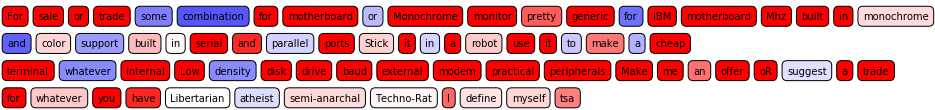

In [8]:

no = 6
cls = 6
print(pths[cls][no])
#print(rmap[cls][no])
plot_text_heatmap(wds[cls][no],rmap[cls][no])


In [9]:
from keras import backend as K
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Conv2D, Input, Dense, MaxPool2D, Flatten, Lambda, GlobalMaxPool2D, Dropout
from keras.models import Model
import tensorflow as tf


print(K.image_data_format())

with tf.device('/GPU:0'):
    inp = Input((None,300,1))
    x = Conv2D(1280,(5,300),activation='relu', name='conv1')(inp)
    
    x = GlobalMaxPool2D('channels_last')(x)
    x = Dense(160,name='fc1',activation='relu')(x)
    z = Dropout(0.35)(x)
    ou = Dense(20,name='fc2')(z)
    out = Dropout(0.35)(ou)
    k_model = Model(inp, out)


trained_weights = model.state_dict()

pytorch_layers = [] # get ptroch layers names and suffixes
for x, l in zip(trained_weights, k_model.layers):
    #print(x)
    #print(l)
    #print(x.find('.'))
    pytorch_layers.append(x[:x.find('.')])

unique_layers = np.unique(pytorch_layers)
print(unique_layers)


for layer in unique_layers:
    weights = trained_weights['{}.weight'.format(layer)].cpu().numpy() # torch weights (nf, ch, x, y)
    biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
    if 'bn' in layer:
        running_mean = trained_weights['{}.running_mean'.format(layer)].cpu().numpy()
        running_var = trained_weights['{}.running_var'.format(layer)].cpu().numpy()
        W = [weights, biases, running_mean, running_var]
    elif 'fc' in layer:
        biases = trained_weights['{}.bias'.format(layer)].cpu().numpy()
        W = [weights.T, biases]
    else:
        W = [np.moveaxis(weights, [0, 1], [3, 2]), biases] # transpose to (x, y, ch, nf) keras version
    k_model.get_layer(layer).set_weights(W)

k_model.summary()

channels_last
['conv1' 'fc1' 'fc2']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 300, 1)      0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, 1, 1280)     1921280   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
fc1 (Dense)                  (None, 160)               204960    
_________________________________________________________________
dropout_1 (Dropout)          (None, 160)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 20)                3220      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20) 

In [10]:
import innvestigate
import innvestigate.applications
import innvestigate.applications.mnist
import innvestigate.utils as iutils
import innvestigate.utils.visualizations as ivis
from innvestigate.utils.tests.networks import base as network_base

In [11]:
## Ensuring Keras model = PyTorch Model

x = dset[72][0]
x = x.reshape((1, -1, 300,1)).numpy() 
print(k_model.predict(x))
x = x.reshape((1, 1,-1, 300)) 
model(torch.as_tensor(x).to(device, dtype=torch.float))

[[ 12.633545 -12.49422  -10.637478 -11.084075 -16.868885 -10.903878
  -20.279446 -15.419546 -14.804499  -9.565522 -12.981065 -11.103493
  -14.103763 -16.032692 -11.70109  -14.674532 -10.584924 -10.684431
   -9.400202 -10.759264]]


tensor([[ 12.6335, -12.4942, -10.6375, -11.0841, -16.8689, -10.9039, -20.2794,
         -15.4195, -14.8045,  -9.5655, -12.9811, -11.1035, -14.1038, -16.0327,
         -11.7011, -14.6745, -10.5849, -10.6844,  -9.4002, -10.7593]],
       device='cuda:0')

In [12]:
methods = ['gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor']
kwargs = [{}, {}, {}, {}]

In [13]:
analyzers = []

for method, kws in zip(methods, kwargs):
    #print(method)
    analyzer = innvestigate.create_analyzer(method, k_model, **kws)
    #analyzer.fit(sample[None,:,:,None], batch_size=256, verbose=1)
    analyzers.append(analyzer)

In [14]:
from keras.layers import Softmax
import time

test_sample_paths = [pths[6][6]]

test_sample_preds = [None]*len(test_sample_paths)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_paths), len(analyzers), 1, dset.data_from_path(test_sample_paths[0])[1].shape[0]])

for i, ridx in enumerate(test_sample_paths):
    #print(dset.get_custom_matrix(243).shape[0])
    x = dset.data_from_path(ridx)[1]
    #print(x.shape)
    #print(ridx)
    #_,y,p = dset[ridx]
    t_start = time.time()
    x = x.reshape((1, -1, 300,1))    

    #presm = k_model.predict_on_batch(x)[0] #forward pass without softmax
    prob = k_model.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    test_sample_preds[i] = y_hat
    print(ridx)
    
    for aidx, analyzer in enumerate(analyzers):

        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        #print(x.shape)
        #print(a.shape)
        analysis[i, aidx] = a
    t_elapsed = time.time() - t_start
    print('Review (%.4fs)'% (t_elapsed))

20news-bydate-test/misc.forsale/76493
Review (1.8721s)


In [15]:
# This is a utility method visualizing the relevance scores of each word to the network's prediction. 
# one might skip understanding the function, and see its output first.
from matplotlib import cm, transforms

def plot_text_heatmap_norm(words, scores, title="", width=10, height=0.2, verbose=0, max_word_per_line=20):
    fig = plt.figure(figsize=(width, height))
    
    ax = plt.gca()

    ax.set_title(title, loc='left')
    tokens = words
    if verbose > 0:
        print('len words : %d | len scores : %d' % (len(words), len(scores)))

    cmap = plt.cm.ScalarMappable(cmap=cm.bwr)
    cmap.set_clim(0, 1)
    
    canvas = ax.figure.canvas
    t = ax.transData

    # normalize scores to the followings:
    # - negative scores in [0, 0.5]
    # - positive scores in (0.5, 1]
    normalized_scores =  0.5 + 0.5*scores / np.max(np.abs(scores))
    
    if verbose > 1:
        print('Raw score')
        print(scores)
        print('Normalized score')
        print(normalized_scores)

    # make sure the heatmap doesn't overlap with the title
    loc_y = -0.2

    for i, token in enumerate(tokens):
        *rgb, _ = cmap.to_rgba(normalized_scores[i], bytes=True)
        color = '#%02x%02x%02x' % tuple(rgb)
        
        text = ax.text(0.0, loc_y, token,
                       bbox={
                           'facecolor': color,
                           'pad': 5.0,
                           'linewidth': 1,
                           'boxstyle': 'round,pad=0.5'
                       }, transform=t)

        text.draw(canvas.get_renderer())
        ex = text.get_window_extent()
        
        # create a new line if the line exceeds the length
        if (i+1) % max_word_per_line == 0:
            loc_y = loc_y -  2.5
            t = ax.transData
        else:
            t = transforms.offset_copy(text._transform, x=ex.width+15, units='dots')

    if verbose == 0:
        ax.axis('off')

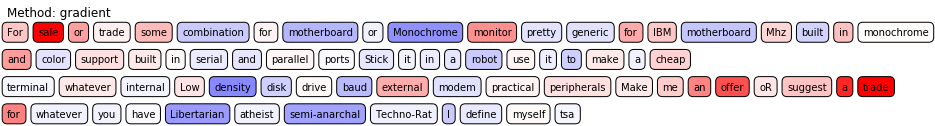

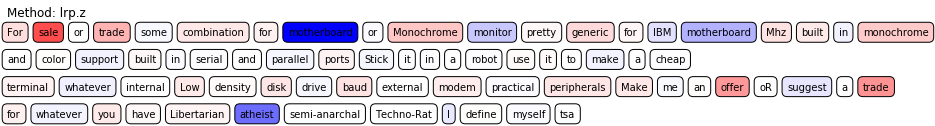

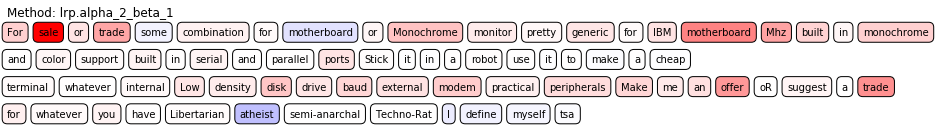

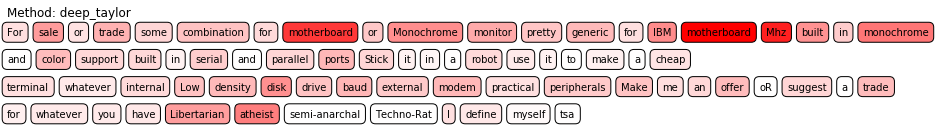

In [16]:
for i, idx in enumerate(test_sample_paths):

    words = dset.data_from_path(idx)[0]
    
    #print('Review(id=%d): %s' % (idx, ' '.join(words)))
    #_,y_true,_2 = dset[idx]
    #y_pred = test_sample_preds[i]

    #print("Pred class : %s %s" %
    #      (y_pred, '✓' if y_pred == y_true else '✗ (%s)' % y_true)
    #     )
                                
    for j, method in enumerate(methods):
        plot_text_heatmap_norm(words, analysis[i, j].reshape(-1), title='Method: %s' % method, verbose=0)
        plt.show()

In [17]:
def get_distortion_curve(x,maps):
    yval = [None]*len(maps)
    #print(len(maps))
    for i in range(len(maps)):
        
        yval[i] = np.zeros(51)
        n = np.random.normal(size=(32,1,x.shape[0],300))
        order = np.argsort(maps[i])[::-1]
        #print(maps[i].shape)
        c = 0
        #print(maps[i].shape)
        with torch.no_grad():
            z = [int(f*x.shape[0]/50) for f in range(51)]
            for k in z:
                
                #print(k)
                n[:,0,order[:k],:] = x[order[:k]]
                out = model(torch.as_tensor(n.astype(np.float32)).to(device))

                x_input = torch.as_tensor(x[None,None,:,:]).to(device, dtype = torch.float)
                x_out = model(x_input)
                highest_dim = int(np.argmax(x_out.cpu().numpy(), axis=1))
                
                yval[i][c] = comp_loss(out,x_out,highest_dim).data.item()
                c += 1

    return yval

In [18]:
w,x = dset.data_from_path(pths[6][6])
m = rmap[6][6]
y = get_distortion_curve(x,[m])

In [19]:
y

[array([-1.31575136e+01, -1.30199919e+01, -1.28363104e+01, -1.25092916e+01,
        -1.23740711e+01, -1.22696028e+01, -1.21049643e+01, -1.17529697e+01,
        -1.15193615e+01, -1.13749762e+01, -1.11590061e+01, -1.10094681e+01,
        -1.08695984e+01, -1.07940054e+01, -1.06075583e+01, -1.05819292e+01,
        -1.04734573e+01, -1.04462681e+01, -1.03820715e+01, -1.02968044e+01,
        -1.00471249e+01, -9.35177898e+00, -9.17099476e+00, -8.72497272e+00,
        -8.43918324e+00, -8.15614605e+00, -8.17897797e+00, -8.19893265e+00,
        -7.84759617e+00, -7.50252247e+00, -7.01482391e+00, -7.07810211e+00,
        -6.87557459e+00, -6.27799845e+00, -6.14297104e+00, -6.08624411e+00,
        -5.85963821e+00, -5.07525349e+00, -4.42069006e+00, -3.87977982e+00,
        -3.62721944e+00, -3.72262502e+00, -3.83212447e+00, -3.83185363e+00,
        -3.80539250e+00, -3.34986115e+00, -3.32579207e+00, -3.16460276e+00,
        -1.49807382e+00, -1.85127532e+00,  3.57627869e-07])]

In [20]:
y2 = get_distortion_curve(x,analysis[0,:,0])

In [21]:
y2

[array([-1.38493805e+01, -1.37844715e+01, -1.37401123e+01, -1.34555044e+01,
        -1.34304075e+01, -1.31483250e+01, -1.29291935e+01, -1.26888762e+01,
        -1.25088501e+01, -1.23991680e+01, -1.23046513e+01, -1.22994843e+01,
        -1.21746521e+01, -1.19644012e+01, -1.16556034e+01, -1.15440130e+01,
        -1.12610016e+01, -1.10727129e+01, -1.07716541e+01, -1.05408459e+01,
        -1.04760637e+01, -1.02570381e+01, -9.81088161e+00, -9.06834316e+00,
        -9.05573463e+00, -8.92783260e+00, -8.62618256e+00, -8.22840309e+00,
        -8.09074306e+00, -7.93211985e+00, -7.54162455e+00, -7.48935461e+00,
        -6.47213316e+00, -6.41097498e+00, -5.90451002e+00, -5.67739439e+00,
        -5.05585861e+00, -4.76102924e+00, -4.62519789e+00, -4.69343662e+00,
        -3.88652158e+00, -3.31601977e+00, -3.29018259e+00, -2.19231606e+00,
        -2.38648105e+00, -2.21187901e+00, -1.30982423e+00, -1.17358959e+00,
        -3.74517053e-01, -1.24286234e+00,  3.57627869e-07]),
 array([-1.31314850e+01, -1

Text(0, 0.5, 'Distortion')

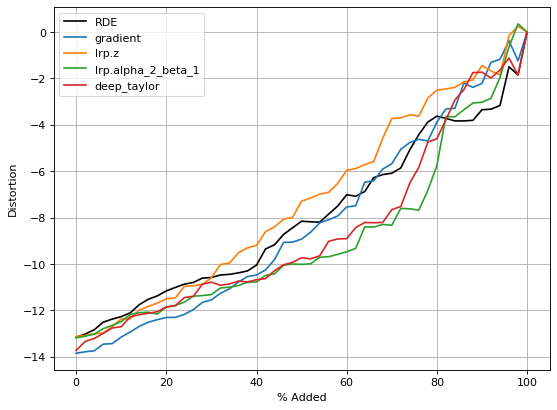

In [22]:
x_ax = list(range(51))
x_ax = [2*k for k in x_ax]
#print(x_ax)

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_ax,y[0],'black')

for i in range(len(y2)):
    plt.plot(x_ax,y2[i])
    
plt.legend(['RDE','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('% Added')
plt.ylabel('Distortion')

In [23]:

test_sample_paths = []
for i in range(140):
    
    #print(i//4)
    #print(i%4)
    #print(pths[i//4][i%4])
    test_sample_paths.append(pths[i//7][i%7])

test_sample_preds = [None]*len(test_sample_paths)

analyzis = [[None]*len(analyzers)]*len(test_sample_paths)
#print(len(test_sample_paths))
for i, ridx in enumerate(test_sample_paths):
 
    #print(i)
    x = dset.data_from_path(ridx)[1]
    #print(x.shape)
    x = x.reshape((1, -1, 300,1))    
    #print(x.shape)
    #print(ridx)
    analyzis[i] = [np.zeros(x.shape[1])]*len(analyzers)
    for aidx, analyzer in enumerate(analyzers):
        
        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        analyzis[i][aidx] = a
        
    #print(analyzis[0][0].shape)
    

In [24]:
y=[np.zeros(51)]*140
y2 = [[np.zeros(51)]*len(analyzers)]*140
for i in range(7):
    for j in range(20):
        #print(pths[j][i])
        #print(test_sample_paths[i+j*4])
        w,x = dset.data_from_path(pths[j][i])
        m = rmap[j][i]
        
        y[j*7 + i] = get_distortion_curve(x,[m])
        y2[j*7 + i] = get_distortion_curve(x,analyzis[j*7+i])

In [25]:
yt = [x[0] for x in y]
z = np.array(yt)
print(z.shape)
print(z.mean(axis=0).shape)
ym = z.mean(axis=0)

(140, 51)
(51,)


In [26]:
print(np.array(y2).shape)
z = np.array(y2)
y2m = z.mean(axis=0)
print(y2m.shape)

(140, 4, 51)
(4, 51)


Text(0, 0.5, 'Distortion')

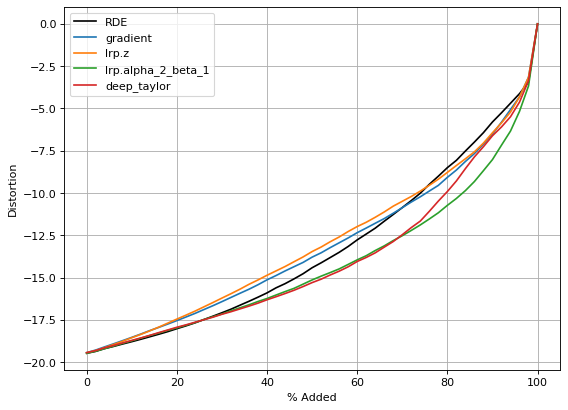

In [27]:
x_ax = list(range(51))
x_ax = [2*k for k in x_ax]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_ax,ym,'black')

for i in range(y2m.shape[0]):
    plt.plot(x_ax,y2m[i])
    
plt.legend(['RDE','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('% Added')
plt.ylabel('Distortion')

In [28]:
def comp_loss_l2(mod,org,h):
    
    
    ### Loss 2
    z = torch.mean((mod[:,:]-org[:,:])**2)
    
    
    return z

def get_distortion_curve_l2(x,maps):
    yval = [None]*len(maps)
    #print(len(maps))
    for i in range(len(maps)):
        
        yval[i] = np.zeros(51)
        n = np.random.normal(size=(32,1,x.shape[0],300))
        order = np.argsort(maps[i])[::-1]
        #print(maps[i].shape)
        c = 0
        #print(maps[i].shape)
        with torch.no_grad():
            z = [int(f*x.shape[0]/50) for f in range(51)]
            for k in z:
                
                #print(k)
                n[:,0,order[:k],:] = x[order[:k]]
                #n[:,0,order[:k],:] = x[order[:k]]
                #print(n.shape)
                #print(x.shape)
                out = model(torch.as_tensor(n.astype(np.float32)).to(device))

                x_input = torch.as_tensor(x[None,None,:,:]).to(device, dtype = torch.float)
                x_out = model(x_input)
                highest_dim = int(np.argmax(x_out.cpu().numpy(), axis=1))
                
                yval[i][c] = comp_loss_l2(out,x_out,highest_dim).data.item()
                c += 1

    return yval

(140, 51)
(51,)
(140, 4, 51)
(4, 51)


Text(0, 0.5, 'Distortion - L2')

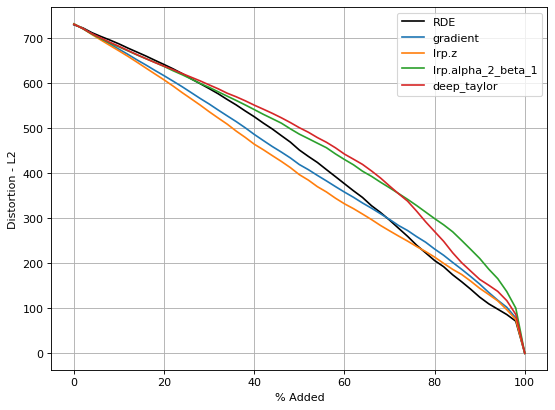

In [29]:
y=[np.zeros(51)]*140
y2 = [[np.zeros(51)]*len(analyzers)]*140
for i in range(7):
    for j in range(20):
        w,x = dset.data_from_path(pths[j][i])
        m = rmap[j][i]
        
        y[j*7 + i] = get_distortion_curve_l2(x,[m])
        y2[j*7 + i] = get_distortion_curve_l2(x,analyzis[j*7+i])
        
yt = [x[0] for x in y]
z = np.array(yt)
print(z.shape)
print(z.mean(axis=0).shape)
ym = z.mean(axis=0)

print(np.array(y2).shape)
z = np.array(y2)
y2m = z.mean(axis=0)
print(y2m.shape)


x_ax = list(range(51))
x_ax = [2*k for k in x_ax]

plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(x_ax,ym,'black')

for i in range(y2m.shape[0]):
    plt.plot(x_ax,y2m[i])
    
plt.legend(['RDE','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('% Added')
plt.ylabel('Distortion - L2')

In [30]:
###### ACC GRAPH
BTCH = 32

def get_acc(x,target,maps):
    yval = [None]*len(maps)
    for i in range(len(maps)):
        
        yval[i] = np.zeros(11)
        n = np.random.normal(size=(BTCH,1,x.shape[0],300))
        order = np.argsort(maps[i])[::-1]
        xt = x[None,None,:,:]
        xt = np.tile(xt,(BTCH,1,1,1))
                
        with torch.no_grad():
            for k in range(1,11):
                
                xt[:,0,order[:k],:] = n[:,0,order[:k],:] 
                out = model(torch.as_tensor(xt.astype(np.float32)).to(device))
                
                highest_dim = np.argmax(out.cpu().numpy(), axis=1)
                temp = [int(x==target) for x in highest_dim]
                #print(temp)
                yval[i][k] = sum(temp)/BTCH
            yval[i][0] = 1
    return yval

In [31]:
w,x = dset.data_from_path(pths[6][6])
m = rmap[6][6]
y = get_acc(x,6,[m])
print(y)

[array([1.     , 0.375  , 0.40625, 0.28125, 0.125  , 0.0625 , 0.03125,
       0.03125, 0.     , 0.     , 0.     ])]


In [32]:
y_acc=[np.zeros(11)]*140
y2_acc = [[np.zeros(11)]*len(analyzers)]*140
for i in range(7):
    for j in range(20):
        #print(pths[j][i])
        #print(test_sample_paths[i+j*4])
        w,x = dset.data_from_path(pths[j][i])
        m = rmap[j][i]
        y_acc[j*7 + i] = get_acc(x,j,[m])
        y2_acc[j*7 + i] = get_acc(x,j,analyzis[j*7+i])
        

In [33]:
yt = [x[0] for x in y_acc]
z = np.array(yt)
print(z.shape)
print(z.mean(axis=0).shape)
yam = z.mean(axis=0)

print(np.array(y2_acc).shape)
z = np.array(y2_acc)
y2am = z.mean(axis=0)
print(y2am.shape)


(140, 11)
(11,)
(140, 4, 11)
(4, 11)


Text(0, 0.5, 'Accuracy')

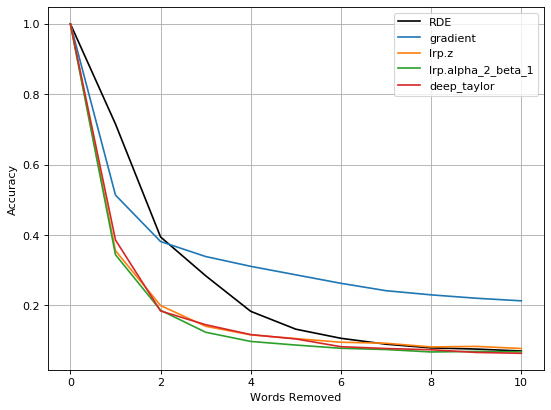

In [34]:


plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(yam,'black')

for i in range(y2am.shape[0]):
    plt.plot(y2am[i])
    
plt.legend(['RDE','gradient', 'lrp.z', 'lrp.alpha_2_beta_1', 'deep_taylor'])
plt.grid(True)
plt.xlabel('Words Removed')
plt.ylabel('Accuracy')

In [35]:
e, sample = dset.data_from_path('exp.txt')
print(e)

sample = sample[None,None,:,:]

x_input = torch.as_tensor(sample).to(device, dtype=torch.float)
x_out = model(x_input.clone()).detach().cpu()

print(np.argmax(x_out))
print(class_names[np.argmax(x_out)])

tt = GenRelMap(sample, num_iters=701, gam=0.995, lr = 8e-3)[0,:,0]

['I', 'am', 'a', 'doctor', 'who', 'needs', 'an', 'urgent', 'hockey', 'puck', 'to', 'treat', 'an', 'innocent', 'patient', 'I', 'need', 'to', 'go', 'to', 'the', 'hospital', 'in', 'my', 'ferrari', 'car', 'I', 'am', 'the', 'best', 'doctor', 'there', 'is', 'in', 'the', 'Middle-East', 'Even', 'the', 'God', 'loves', 'me', 'I', 'believe', 'in', 'God', 'and', 'Jesus', 'I', 'am', 'making', 'a', 'medicine', 'for', 'people', 'I', 'love', 'my', 'cars', 'so', 'much', 'I', 'am', 'a', 'professor', 'at', 'Univeristy', 'of', 'Mumbai', 'My', 'guns', 'are', 'always', 'ready', 'to', 'shoot', 'I', 'use', 'Windows', 'X', 'PC', 'I', 'hate', 'Windows', 'PC', 'I', 'like', 'Mac', 'more', 'Actually', 'I', 'am', 'atheist']
tensor(10)
rec.sport.hockey


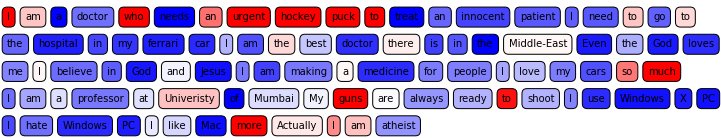

In [36]:
#plot_text_heatmap(e,((tt-np.min(tt))/(np.max(tt)-np.min(tt)))**1)
plot_text_heatmap(e,tt)

#print(path)

In [77]:
tt

array([1.        , 0.6099801 , 0.        , 0.21561044, 1.        ,
       0.        , 0.7746433 , 1.        , 1.        , 1.        ,
       1.        , 0.        , 0.17719619, 0.15515548, 0.18578473,
       0.18978164, 0.16170076, 0.17891784, 0.21419063, 0.323195  ,
       0.2324938 , 0.11095183, 0.18094496, 0.12365082, 0.07336609,
       0.10363479, 0.39749905, 0.16433054, 0.72613114, 0.41559795,
       0.13581781, 0.5399057 , 0.1422454 , 0.2400757 , 0.03633679,
       0.42670143, 0.0526155 , 0.34672937, 0.06091128, 0.06251428,
       0.26712143, 0.5081178 , 0.18959709, 0.18745981, 0.07977492,
       0.5089946 , 0.03613468, 0.19864088, 0.10790619, 0.1262515 ,
       0.51752305, 0.11467031, 0.20702386, 0.29824272, 0.2762786 ,
       0.33655277, 0.27487856, 0.16821235, 0.57316184, 1.        ,
       0.25918093, 0.3070778 , 0.47983348, 0.23169552, 0.41615283,
       0.62690264, 0.        , 0.43769404, 0.50175166, 1.        ,
       0.4875111 , 0.28384927, 0.3430865 , 0.9930698 , 0.35515

In [37]:
from keras.layers import Softmax
import time

test_sample_paths = [1]

test_sample_preds = [None]*len(test_sample_paths)

# a variable to store analysis results.
analysis = np.zeros([len(test_sample_paths), len(analyzers), 1, dset.data_from_path('exp.txt')[1].shape[0]])

for i, ridx in enumerate(test_sample_paths):
    #print(dset.get_custom_matrix(243).shape[0])
    e, x = dset.data_from_path('exp.txt')

    #print(x.shape)
    #print(ridx)
    #_,y,p = dset[ridx]
    t_start = time.time()
    x = x.reshape((1, -1, 300,1))    

    #presm = k_model.predict_on_batch(x)[0] #forward pass without softmax
    prob = k_model.predict_on_batch(x)[0] #forward pass with softmax
    y_hat = prob.argmax()
    print(ridx)
    
    for aidx, analyzer in enumerate(analyzers):

        a = np.squeeze(analyzer.analyze(x))
        a = np.sum(a, axis=1)
        #print(x.shape)
        #print(a.shape)
        analysis[i, aidx] = a
    t_elapsed = time.time() - t_start
    print('Review (%.4fs)'% (t_elapsed))

1
Review (0.0239s)


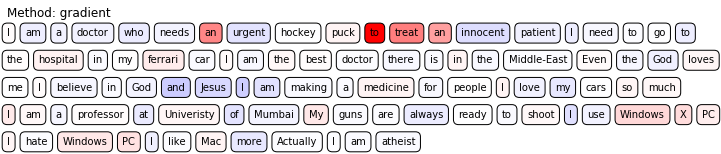

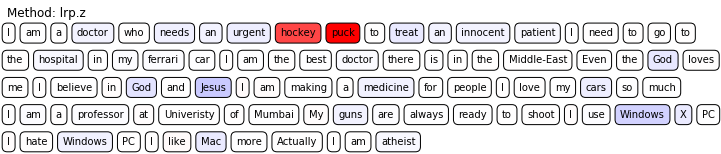

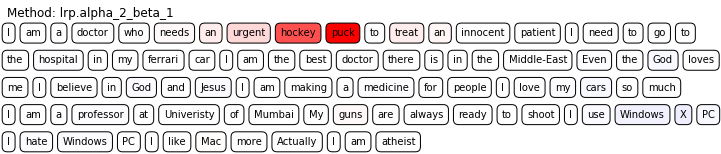

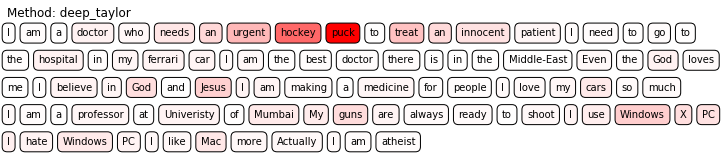

In [38]:
for i, idx in enumerate(test_sample_paths):

    words, sample = dset.data_from_path('exp.txt')

    
    #print('Review(id=%d): %s' % (idx, ' '.join(words)))
    #_,y_true,_2 = dset[idx]
    #y_pred = test_sample_preds[i]

    #print("Pred class : %s %s" %
    #      (y_pred, '✓' if y_pred == y_true else '✗ (%s)' % y_true)
    #     )
                                
    for j, method in enumerate(methods):
        plot_text_heatmap_norm(words, analysis[i, j].reshape(-1), title='Method: %s' % method, verbose=0)
        plt.show()

In [83]:
print(analysis[0,2])

[[ 1.73010267e-02  1.13546737e-01  0.00000000e+00  1.14870834e+00
   2.41803363e-01  1.01547992e+00  1.04787445e+00  1.28463054e+00
   1.42996585e+00  7.53001070e+00  0.00000000e+00  1.00294650e+00
   1.60200346e+00  1.42103148e+00  5.46441495e-01  8.13297555e-02
   1.61313578e-01  0.00000000e+00  5.57213128e-01  0.00000000e+00
   1.86310187e-01  1.10310614e+00  2.52408803e-01  8.77555490e-01
   1.59396791e+00  1.74411225e+00  1.84851140e-01  4.96750057e-01
   8.92379582e-02  1.35266721e-01  2.20626965e-01 -7.78155476e-02
  -4.81968746e-05  1.58126969e-02  1.25528593e-03  0.00000000e+00
  -4.12101485e-02 -1.54305268e-02 -1.73574507e-01  1.19684443e-01
   9.28913355e-02  3.88056301e-02 -1.75106034e-01  7.17913285e-02
   9.64338243e-01  0.00000000e+00  1.16520405e+00  2.54832149e-01
   3.02530348e-01  1.84611678e-01  0.00000000e+00  5.63188672e-01
   6.54547364e-02  2.93114722e-01  2.20543802e-01  1.00134110e+00
   1.35673380e+00  5.83330107e+00  5.19663930e-01  7.09042132e-01
   2.99022